### CART生成

&emsp;&emsp;决策树的生成就是递归的构建二叉决策树的过程，对回归树用平方误差最小化准则，对分类树用基尼指数最小化准则，进行特征选择，生成二叉树。

1. 回归树的生成

&emsp;&emsp;当输入空间的划分确定时，可以用平方误差$\sum_{x_{i}\in R_{m}}(y_{i} - f(x_{i}))$来表示回归树对于训练数据的预测误差，用平方误差最小的准则来求解每个单元上的最优输出值，易知，单元$R_{m}$上的$c_{m}$的最优值


在树的构建过程中，使用字典存储树的结构，该字典包含以下4个元素。
1. 代切分的特征
2. 代切分的特征值
3. 左子树
4. 右子树

函数createTree的伪代码大致如下：

    找到最佳的代切分特征：
        如果该节点不能再分，将该节点存为叶节点
        执行二元切分
        在左子树调用createTree()方法
        在右子树调用createTree()方法

In [5]:
def bin_split_data(dataset,feature,value):
    mat0 = dataset.loc[dataset[feature] <= value]
    mat1 = dataset.loc[dataset[feature] > value]
    return mat0,mat1

In [15]:
# 获取子节点的值
def reg_leaf(dataset,label):
    return np.mean(dataset[label])

In [83]:
class Node:
    def __init__(self, isLeaf=True, feature_val=None, feature_name=None, feature_axis=None, y=None):
        self.isLeaf = isLeaf
        self.feature_val = feature_val
        self.y = y
        self.feature_name = feature_name
        self.feature_axis = feature_axis
        self.tree = {}
        if self.isLeaf:
            self.result = {'y':self.y}
        else:
            self.result = {
                'feature_val': self.feature_val,
                'feature_name': self.feature_name,
                'tree': self.tree
            }

    def __repr__(self):
        return '{}'.format(self.result)

    def add_child(self, feature_val, left_tree, right_tree):
        self.tree['left'] = left_tree
        self.tree['right'] = right_tree

    def predict(self, features):
        '''
        features是一个特征的列表
        '''
        if self.isLeaf:
            return self.y
        vec_val = features[self.feature_axis]
        if vec_val <= self.feature_val:
            return self.tree['left'].predict(features)
        else:
            return self.tree['right'].predict(features)


class DTree:
    def __init__(self, tolS, tolN):
        # 容许的误差下降值，如果切分后误差下降值< tolS，停止划分，作为叶子节点
        self.tolS = tolS
        # 容许的最少样本数，如果剩下的样本数<tolN,停止划分，作为叶子节点
        self.tolN = tolN
        self._tree = {}

    # 计算数据集的平均值
    def regleaf(self,dataset, label):
        '''
        dataset:df格式
        '''
        # 最后一列
        return dataset[label].mean()

    # 计算数据集的方差和
    def regErr(self,dataset,label):
        res = np.var(dataset[label])
        return res

    # 切割数据
    def bin_split_data(self ,dataset, feature, value):
        mat0 = dataset.loc[dataset[feature] <= value]
        mat1 = dataset.loc[dataset[feature] > value]
        return mat0, mat1

    # 从数据集中选择最好的特征进行划分，返回feature_axis,feature_val,如果不能划分，返回None ,叶子节点值
    def choose_best_split(self,dataset, tolS, tolN):
        # 1.如果数据集的所有值都相等
        feature_list = dataset.columns[:-1]
        label = dataset.columns[-1]

        if len(dataset[label].value_counts()) == 1:
            return None, self.regleaf(dataset, label)
        # 不划分的误差和
        S = self.regErr(dataset, label)
        # 记录最小的误差和，对应的特征index,以及划分值
        best_s = float('inf')
        best_index = None
        best_value = None

        for feat_index, feat_name in enumerate(feature_list):
            for splitVal in dataset[feat_name].unique():
                mat0, mat1 = self.bin_split_data(dataset, feat_name, splitVal)
                # 切割后的数据过少
                if mat0.shape[0] < tolN or mat1.shape[0] < tolN:
                    continue
                new_s = self.regErr(mat0, label) + self.regErr(mat1, label)
                if new_s < best_s:
                    best_s = new_s
                    best_index = feat_index
                    best_value = splitVal
        # 如果误差减少不大，则不进行划分
        if S - best_s < tolS:
            return None, self.regleaf(dataset,label)
        return best_index, best_value
    
    # 判断是否是子树
    def isTree(self,node):
        return not node.isLeaf

    def  
    
    def train(self, dataset):
        feat_index, feat_val = self.choose_best_split(dataset, self.tolS, self.tolN)
        features_list = dataset.columns[:-1]
        label = dataset.columns[-1]

        if feat_index is None:
            # 建立叶子节点
            return Node(isLeaf=True, y=self.regleaf(dataset, label))
        else:
            node_tree = Node(isLeaf=False, feature_val=feat_val, feature_name=features_list[feat_index],
                             feature_axis=feat_index)
            mat0, mat1 = self.bin_split_data(dataset, features_list[feat_index], feat_val)
            left_tree = self.train(mat0)
            right_tree = self.train(mat1)
            node_tree.add_child(feat_val,left_tree,right_tree)
            return node_tree

    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree

    def predict(self, X_test):
        return self._tree.predict(X_test)

In [69]:
import pandas as pd
def load_df(file_name):
    temp_list = []
    with open(file_name,'r') as f:
        for line in f:
            vec = line.strip().split(' ')
            x = float(vec[0])
            y = float(vec[1])
            temp_list.append([x,y])
    return pd.DataFrame(temp_list,columns=['x','y'])

In [70]:
read_file = './ex_0.txt'
data_df = load_df(read_file)

In [86]:
data_df.shape

(200, 2)

In [89]:
tol_s = 0
tol_n = 2
dt = DTree(tol_s,tol_n)
dt.fit(data_df)

{'feature_val': 0.39435, 'feature_name': 'x', 'tree': {'left': {'feature_val': 0.197834, 'feature_name': 'x', 'tree': {'left': {'y': -0.023838155555555553}, 'right': {'y': 1.0289583666666666}}}, 'right': {'feature_val': 0.582002, 'feature_name': 'x', 'tree': {'left': {'y': 1.980035071428571}, 'right': {'feature_val': 0.797583, 'feature_name': 'x', 'tree': {'left': {'y': 2.9836209534883724}, 'right': {'y': 3.9871632}}}}}}}

In [47]:
X_test = [0.152324]

In [75]:
dt.predict(X_test)

-0.023838155555555553

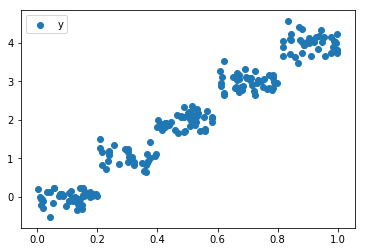

In [76]:
import matplotlib.pyplot as plt

plt.scatter(data_df.iloc[:,0],data_df.iloc[:,1])
plt.legend()

### 树剪枝
&emsp;&emsp;通过降低决策树的复杂度来避免过拟合的过程成为剪枝
1. 预剪枝：设定提前的终止条件
2. 后剪枝：需要使用训练数据和验证数据，进行合并节点

#### 后剪枝
首先根据训练数据集，使得构建的树足够大，足够复杂，便于剪枝，接下来从上而下找到叶子节点，用测试集来判断将这些叶节点合并是否能够降低测试误差。如果可以就合并。
函数prune()伪代码如下:

    基于已有的树切分测试数据：
        如果存在任一子集是一颗树，则在该子集递归调用剪枝过程
        计算将当前两个叶节点合并后的误差
        计算不合并的误差
        如果合并会降低误差的话，就合并